# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

Prepare the ICS transfer functions from these files.

In [4]:
eleceng = phys.me + 10**np.arange(0, 12, 0.4)
photeng = 10**np.arange(-4, 12, 0.4)
T = 10

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

Check that everything is working as expected...

[0.0001, 10000000000000.0, 1e-16, 1000.0]

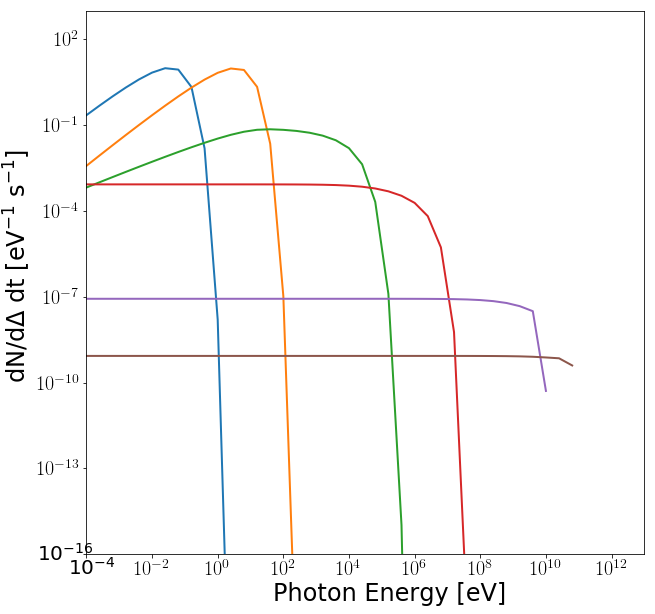

In [5]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/d$\Delta$ dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [6]:
sec_elec_tf = copy.deepcopy(engloss_tf)

for in_eng, spec in zip(sec_elec_tf.get_in_eng(), sec_elec_tf):
    spec.engloss_rebin(in_eng, sec_elec_tf.get_in_eng())

[0.0001, 10000000000000.0, 1e-16, 1000.0]

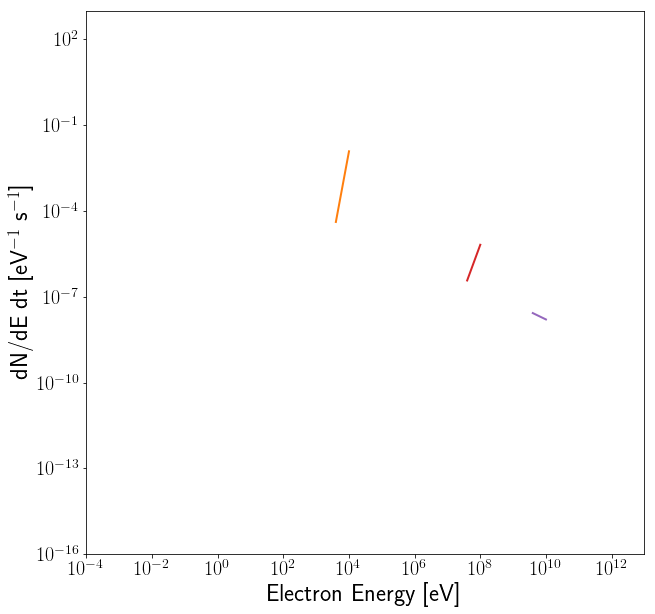

In [7]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

sec_elec_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Electron Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [8]:
sec_phot_tf = tf.TransFuncAtEnergy([ICS_tf[0]], ICS_tf.in_eng[0], ICS_tf.dlnz)
ICS_tf_toteng = np.array([spec.toteng() for spec in ICS_tf])
for phot_spec, elec_spec in zip(ICS_tf, sec_elec_tf):
    phot_spec_from_sec_elec = ICS_tf.sum_specs(elec_spec.toteng('bin')/ICS_tf_toteng)
    sec_phot_tf.append(Spectrum(ICS_tf.get_eng(), phot_spec_from_sec_elec))
    sec_phot_tf.in_eng.append()
    

AttributeError: 'TransFuncAtRedshift' object has no attribute 'in_eng'

In [ ]:
test_eng = np.array([1,2,3,4,5])
test_dNdE = np.array([1,1,1,1,1])
a = Spectrum(test_eng, test_dNdE)

In [ ]:
a.toteng('bin')